In [1]:
from numpy.fft import fft, ifft, fft2, ifft2, ifftshift, fftshift
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


[0, 512, 0, 512]


Text(0, 0.5, 'y')

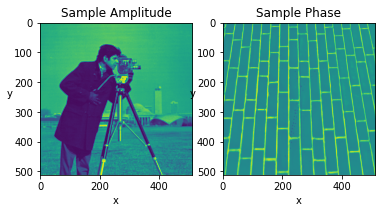

In [2]:
#creating the input amplitude/phase objects
from skimage import data
objectAmplitude = np.double(data.camera())
phase = np.double(data.brick())
phase = np.pi * phase / np.max(phase)
obj = objectAmplitude * np.exp(1j * phase)
fig, ax = plt.subplots(1,2)

N, M = obj.shape

dims=[0,N,0,M]
print(dims)
amplitude_img = ax[0].imshow(np.abs(obj))
phase_img = ax[1].imshow(np.angle(obj))

ax[0].set_title('Sample Amplitude')
ax[1].set_title('Sample Phase')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)

ax[1].set_xlabel('x')
ax[1].set_ylabel('y', rotation = 0)

In [3]:
#input: 1-D LED array position vectors X, Y
#output: the kx_relative and ky_relative vectors
def XYtoRel(X,Y,LEDheight):       
    X,Y = np.meshgrid(X,Y)
    
    X = X.flatten()
    Y = Y.flatten()

    rho = np.sqrt(X**2 + Y**2 + LEDheight**2)
    kx_relative = X/rho
    ky_relative = Y/rho
    return kx_relative, ky_relative





In [10]:
def shiftCompare(xshift,yshift):
    #define LED specifications
    arraysize = 15
    LEDgap = 4 #4mm between adj LED's
    LEDheight = 90 # 90mm between LED and sample

    # 1-D x and y position vectors 
    xloc = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDgap
    yloc = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDgap
    # SHIFTED x and y position vectors
    xloc_shift = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDgap + xshift
    yloc_shift = np.linspace(-(arraysize//2), arraysize//2, arraysize)*LEDgap + yshift

    kx_relative, ky_relative = XYtoRel(xloc,yloc,LEDheight)
    kx_relative_shift, ky_relative_shift = XYtoRel(xloc_shift,yloc_shift,LEDheight)


    [m,n] = obj.shape          #image size of the high resolution object

    #SYSTEM PARAMETERS
    waveLength = .63e-6
    k0 = 2*np.pi/waveLength
    spsize = 2.75e-6              #camerapixelsize/magnification pixel size
    scaling_factor = 4              
    psize = spsize/scaling_factor #hi-res pixel size (smaller than the sensor pixel size)
    NA= 0.08
    m1 = m//(scaling_factor)
    n1 = n//(scaling_factor)        #image size of the final output (low res)
    imSeqLowRes = np.zeros([m1,n1, arraysize**2]) #image sequence of low-resolution images. 225 (128x128) images for 225 LEDs!
    imSeqShifts = np.zeros([m1,n1,arraysize**2])
    kx = k0 * (kx_relative)
    ky = k0 * ky_relative
    #print(kx-kx_shift)
    kx_shift = k0 * kx_relative_shift
    ky_shift = k0 * ky_relative_shift

    dkx = 2*np.pi/(psize * n)
    dky = 2*np.pi/(psize * m)
    cutoffFrequency = NA*k0
    kmax= np.pi/spsize

    kx_lowres = np.linspace(-kmax, kmax, n1,endpoint=False)
    ky_lowres = np.linspace(-kmax, kmax, m1,endpoint=False)
    kxm, kym = np.meshgrid(kx_lowres, ky_lowres)
    CTF = ((kxm**2 + kym **2) < cutoffFrequency ** 2)
    objectFT = fftshift(fft2(obj))



    for i in range(arraysize**2):
        kxc = np.int((n)/2 + kx[i]/dkx)
        #print(kx[i])
        kyc = np.int((m)/2 + ky[i]/dky)
        kyl = np.int(kyc - (m1)/2)
        kyh = np.int(kyc + (m1)/2)
        kxl = np.int(kxc - (n1)/2)
        kxh = np.int(kxc + (n1)/2)
        imSeqLowFT_mask = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh]) * CTF
        imSeqLowRes[:,:,i] = np.abs(ifft2(ifftshift(imSeqLowFT_mask)))

        kxc = np.int((n)/2 + kx_shift[i]/dkx)
        #print("SHFITED", kx_shift[i])
        kyc = np.int((m)/2 + ky_shift[i]/dky)
        kyl = np.int(kyc - (m1)/2)
        kyh = np.int(kyc + (m1)/2)
        kxl = np.int(kxc - (n1)/2)
        kxh = np.int(kxc + (n1)/2)

        imSeqLowFT = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh])
        imSeqLowFT_mask = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh]) * CTF
        imSeqShifts[:,:,i]= np.abs(ifft2(ifftshift(imSeqLowFT_mask)))
    print(ky[127])

    #print(imSeqLowRes)
    #brightfield images are around 126-128
    i = 112


    fig, ax = plt.subplots(1,2)

    him = ax[0].imshow(np.abs(fftshift(fft2(imSeqLowRes[:,:,i]))), norm=colors.LogNorm() )
    him = ax[1].imshow(np.abs(fftshift(fft2(imSeqShifts[:,:,i]))), norm=colors.LogNorm() )
    
    
    ax[0].set_title("0 shift, low res k-space")
    ax[1].set_title("x shift: " + str(xshift) +"\nyshift: " + str(yshift))
    plt.tight_layout()




442821.08433566365


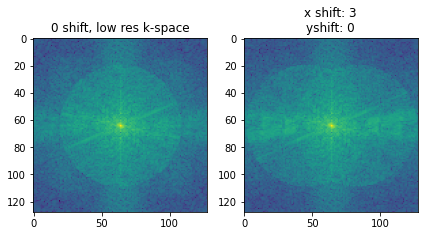

In [11]:
shiftCompare(3,0)

In [102]:
from scipy.ndimage.filters import gaussian_filter
#plots intensity vs r value of image derivative and second derivative values (image gradients)
#input: low-resolution brightfield image
def findEdge(im):
    im = np.log10(np.abs(fftshift(fft2(np.double(im))))) #obtain fourier spectrum of image
    im_normalized = im/np.mean(im) #divide out the mean spectrum
    im_blurred = gaussian_filter(im_normalized, sigma=2) #convolving with the Gaussian Kernel with std.dev = 2 pixels
    im_gradient = gradientImage(im_blurred)[0]
    im_gradient2 = gradientImage(im_blurred)[1]
    fig, ax = plt.subplots(1,4)
    plt.subplots_adjust(left=None, bottom=None, right=3, top=None, wspace=None, hspace=None)   
    him0 = ax[0].imshow(np.abs(im))
    him1 = ax[1].imshow(np.abs(im_normalized))
    him2 = ax[2].imshow(np.abs(im_blurred))
    him3 = ax[3].imshow(np.abs(im_gradient))

    
    ax[0].set_title("Low-Res Fourier Spectrum")
    ax[1].set_title("Fourier Spectrum Divided by Mean")
    ax[2].set_title("Mean spectrum convolved with gaussian kernel!")
    ax[3].set_title("Gradient (1st order)")
